# Real Time Style Transfer - Keras

In the previous style transfer notebooks, we explored how the style of a painting can be applied to a content image. However, that had a limitation since we had to train every single combination of style image and content image separately.

Then, while working on super resolution, we saw how we could train a neural network to learn how to enhance the resolution of images. 

In this notebook, we will be exploring that same concept we used for super resolution. We will be training a neural network which can produce a stylized image given any content image for *one particular style*.

We will be implementing the architecture present in this paper ( same one as super resolution) :

Reference : arxiv.org/abs/1603.08155

**NOTE**

This notebook assumes the knowledge which has been explained in the super resolution notebook. So when in doubt, please consult that notebook.

## Imports

In [46]:
from __future__ import division,print_function
from PIL import Image
import gc,re

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

from keras.models import Model
from keras.layers import Input, UpSampling2D, Convolution2D, Activation, merge, Conv2DTranspose, Lambda, Add
#from keras.layers.merge import Add
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from importlib import reload
from keras import backend as K
from keras.datasets import imdb

np.random.seed(7)

from keras.preprocessing.image import load_img, img_to_array

import bcolz
from IPython.display import FileLink
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from keras import metrics
from scipy.misc import imsave
import imageio

%matplotlib inline

In [149]:
PATH = 'data/real_time_style_transfer/'
RESULTS = PATH + 'results/'
MODELS = PATH + 'models/'
CONTENT_DATA_PATH = 'data/super_resolution/trn_resized_288.bc'
STYLE_PATH = PATH + 'starry-night.jpg'

if not os.path.exists(MODELS):
    os.mkdir(MODELS)

if not os.path.exists(RESULTS):
    os.mkdir(RESULTS)


The idea behind real time style transfer is the same as that for super resolution. Instead of taking a style image and a content image and then feeding them into an optimizer to minimize a loss function, we will be training a conv model - Image Transform Net, and make it capable of producing a stylized image given any content image and one particular style image. We will then be using VGG as a loss function to train our Image Transform Net. 

For more info on this, please look at the super resolution notebook.

Now, let us look at the architecture of the Image Transform Net.

Reference : http://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16Supplementary.pdf

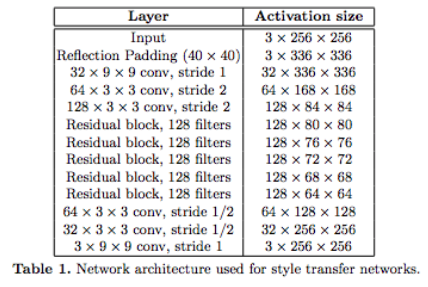

In [4]:
Image.open(PATH+'rtst.png')

As we can see above, the model does not use normal padding (where we just pad with zeros). Instead it uses reflection padding. So, now is the time to learn how to create a custom layer in Keras!

Reference : https://keras.io/layers/writing-your-own-keras-layers/

Reference : https://www.tensorflow.org/api_docs/python/tf/pad

In [16]:
from keras import backend as K
from keras.engine.topology import Layer

import tensorflow as tf

In [23]:
class ReflectionPadding2D(Layer):
    def __init__(self, output_dim, padding = (1, 1), **kwargs):
        self.padding = padding
        self.output_dim = output_dim
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def build(self, input_shape):
        super(ReflectionPadding2D, self).build(input_shape)

    def call(self, x):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 
                input_shape[1] + 2 * self.padding[0], 
                input_shape[2] + 2 * self.padding[1], 
                input_shape[3])

We can easily create the above custom layer by following the reference links above.

Now that we have a custom layer, we should first test it.

In [8]:
arr_hr = bcolz.open(CONTENT_DATA_PATH)[:]

In [21]:
shape = arr_hr[0].shape
shape

(288, 288, 3)

In [24]:
inp = Input(shape=(288,288,3))
ref_out = ReflectionPadding2D(output_dim=(1,288,288,3), padding=(40,10))(inp)

test_ref_model = Model(inputs=inp, outputs=ref_out)
test_ref_model.compile('adam', 'mse')

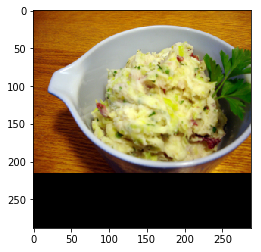

In [36]:
plt.imshow(arr_hr[10].astype('uint8'));plt.show()

In [37]:
preds = test_ref_model.predict(arr_hr[10:11])

In [39]:
preds.shape

(1, 308, 368, 3)

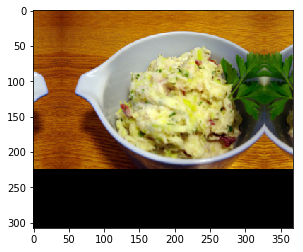

In [40]:
plt.imshow(preds[0].astype('uint8'));plt.show()

Now that we have created a custom padding layer which we can use in out model, let us proceed further.

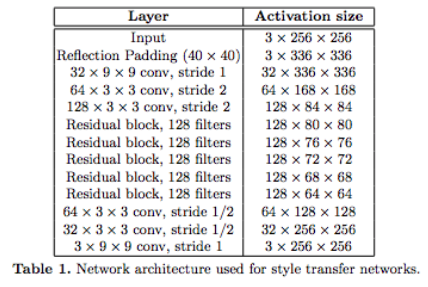

In [42]:
Image.open(PATH+'rtst.png')

Residual blocks have been explained in the super resolution notebook, please refer to that for details.

Now some observations about the architecture : 

* On doing the convolutions inside the residual blocks, we see that the size of the activations is decreasing by 4 across height and width. That means, while doing the convolutions we are not using the padding as 'same' but instead we are using 'valid' paddings.

* We are using reflection padding of 40X40 since we want the input and output images to be of same size.
    * Let initial size be x. 
    * There are two stride 2 conv layers before the first residual block. That means there two layers decrease size by 4. x---> x/4
    * Each residual block is decreasing the size by 4. There are 5 residual blocks. x ----> (x/4 - 20)
    * There are two 1/2 stride conv blocks after the residual blocks. These can be either Deconvolution (also called fractionally strided conv) layers or Upsampling layers. Each of these increase the size by 2. 
    x -->(x/4 -20)* 4 => x - 80
    * Thus in the overall network, we are decreasing the size by 80 across height and width. Hence, we apply padding of 40x40

* Note : As we had seen in the super resolution notebook, Deconv layers lead to a checkerboard pattern. We had used Upsampling layers instead to clear the image of checkerboard patterns. Hence we will be using Upsampling layers here too.

Copying the block creation methods over from the super resolution notebook. We have made slight changes to the resnet_block to change to 'valid' paddings.

In [43]:
def convolution_block(inp, n_filters, kernel_size, strides, padding='same', add_activation = True):
    x = Convolution2D(filters=n_filters, kernel_size=kernel_size, strides=strides, padding=padding)(inp)
    x = BatchNormalization()(x)
    if add_activation:
        x = Activation('relu')(x)
    return x

In [47]:
#resnet block is also called the residual block
def resnet_block(inp, n_filters=64):
    
    x = convolution_block(inp=inp,n_filters=n_filters, kernel_size=(3,3), 
                          strides=(1,1),padding='valid',
                          add_activation=True)
    
    x = convolution_block(x, n_filters, (3,3), (1,1), 'valid', add_activation=False)
    
    # Since we are using valid paddings, the size of the image decreases by 2 across each axis. 
    # So before adding the inp to this block and the output of the above 2 conv blocks, we need to crop the inp
    
    inp = Lambda(lambda x : x[:, 2:-2, 2:-2])(inp)
    
    x = Add()([x, inp])
    return x
    

In [48]:
def upsample_block(inp, n_filters, kernel_size):
    x = UpSampling2D()(inp)
    x = Convolution2D(filters=n_filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [49]:
shape

(288, 288, 3)

In [96]:
arr_hr.shape

(19439, 288, 288, 3)

In [122]:
def get_image_transform_net_model():
    inp = Input(shape, name='input_image_transform_net')
    
    x = ReflectionPadding2D(output_dim=(1, shape[0], shape[1], shape[2]), padding=(40,40) )(inp)
    
    x = convolution_block(x, n_filters=32, kernel_size=(9,9), strides=(1,1))
    x = convolution_block(x, n_filters=64, kernel_size=(3,3), strides=(2,2))
    x = convolution_block(x, n_filters=128, kernel_size=(3,3), strides=(2,2))
   
    for i in range(0,5):
        x = resnet_block(x, n_filters=128)
        
    x = upsample_block(x, n_filters=64,kernel_size=(3,3))
    x = upsample_block(x, n_filters=32,kernel_size=(3,3))
    
    x = Convolution2D(filters=3, kernel_size=(9,9), padding='same', activation='tanh')(x)
    outp = Lambda(lambda x : (x+1)*127.5)(x)
    return inp,outp

In [123]:
inp,outp = get_image_transform_net_model()

In [126]:
## Inputs to VGG were pre-processed in a certain way
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

vgg_inp = Input(shape, name='input_vgg')

In [127]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_vgg (InputLayer)       (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_26 (Lambda)           (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

Now the approach is almost the same as we trained our Image Transform Net for the super resolution. Only difference will be that we would have different loss functions.

Since VGG is only being used as a loss function, we should not be training its layers.

In [128]:
for layer in vgg16.layers:
    layer.trainable = False

In [129]:
def get_output_layers_of_vgg(i):
    layer_name = 'block' + str(i) + '_conv2'
    return vgg16.get_layer(layer_name).output

In [130]:
outputs = [] 
for i in [2,3,4,5]:
    outputs.append(get_output_layers_of_vgg(i))

vgg_content = Model(inputs=vgg_inp, outputs=outputs)

In [131]:
vgg_content.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_vgg (InputLayer)       (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_26 (Lambda)           (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

In [132]:
vgg_act = vgg_content(vgg_inp)
vgg_trained = vgg_content(outp)

Now the difference is in how we are calculating loss. So we need new kinds of loss functions. Fortunately for us, we have already implemented them in the Neural Style Transfer notebooks.

Also let us fetch our style image

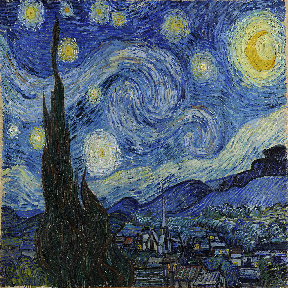

In [133]:
style = Image.open(STYLE_PATH)
style = style.resize((shape[0], shape[1]))
style

In [134]:
style_arr = np.asarray(style)
style_arr.shape

(288, 288, 3)

In [135]:
style_targets = [K.variable(x) for x in vgg_content.predict(np.expand_dims(style_arr,0))]

In [136]:
style_targets

[<tf.Variable 'Variable_12:0' shape=(1, 144, 144, 128) dtype=float32_ref>,
 <tf.Variable 'Variable_13:0' shape=(1, 72, 72, 256) dtype=float32_ref>,
 <tf.Variable 'Variable_14:0' shape=(1, 36, 36, 512) dtype=float32_ref>,
 <tf.Variable 'Variable_15:0' shape=(1, 18, 18, 512) dtype=float32_ref>]

In [137]:
vgg_act

[<tf.Tensor 'model_9/block2_conv2/Relu:0' shape=(?, 144, 144, 128) dtype=float32>,
 <tf.Tensor 'model_9/block3_conv2/Relu:0' shape=(?, 72, 72, 256) dtype=float32>,
 <tf.Tensor 'model_9/block4_conv2/Relu:0' shape=(?, 36, 36, 512) dtype=float32>,
 <tf.Tensor 'model_9/block5_conv2/Relu:0' shape=(?, 18, 18, 512) dtype=float32>]

In [138]:
vgg_trained

[<tf.Tensor 'model_9_1/block2_conv2/Relu:0' shape=(?, 144, 144, 128) dtype=float32>,
 <tf.Tensor 'model_9_1/block3_conv2/Relu:0' shape=(?, 72, 72, 256) dtype=float32>,
 <tf.Tensor 'model_9_1/block4_conv2/Relu:0' shape=(?, 36, 36, 512) dtype=float32>,
 <tf.Tensor 'model_9_1/block5_conv2/Relu:0' shape=(?, 18, 18, 512) dtype=float32>]

In [139]:
# This was our gram matrix in the neural style tasnfer notebook : 
"""
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    gm = K.dot(features, K.transpose(features))
    gm_normalized = gm / (x.get_shape().num_elements()) # divide by the total elements in that tensor
    return gm_normalized
"""

'\ndef gram_matrix(x):\n    features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))\n    gm = K.dot(features, K.transpose(features))\n    gm_normalized = gm / (x.get_shape().num_elements()) # divide by the total elements in that tensor\n    return gm_normalized\n'

If we look at the previous version, we see that it doesnt work on batches. This is because in the previous notebook, we had just one content image and one style image. However, in this case, we want to train out Image Tranform Net on a bunch on content images. As such, we need to build a 'batch' version of gram matix for faster processing.

In [140]:
def gram_matrix_batched(x):
    x = K.permute_dimensions(x,(0,3,1,2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    feat_T = K.permute_dimensions(feat, (0,2,1))
    
    dot_prod = K.batch_dot(feat,feat_T)
    
    n_elements = K.prod(K.cast(s[1:], K.floatx())) #floatx() returns the default float type, as a string 
    
    return dot_prod/n_elements

In [141]:
def get_mean_squared_error_of_diff(diff):
    n_dims = K.ndim(diff)
    dims_list = list(range(1,n_dims))   # This returns [1,2,3] for a tensor which has 4 dimensions
    
    diff_sq = diff**2
    rmse = K.sqrt(K.mean(diff_sq, dims_list))   # We will be calculating error along each axis
    
    return K.expand_dims(rmse,0)  #need to convert back to batch size

In [168]:
w=[0.1, 0.2, 0.6, 0.1]

def loss(x):
    n_layers = len(w)
    total_loss = 0
    
    for i in range(n_layers):
        style_loss = get_mean_squared_error_of_diff(\
                        gram_matrix_batched(x[i+n_layers]) - gram_matrix_batched(style_targets[i]) ) /8.
        
        content_loss = get_mean_squared_error_of_diff( x[i+n_layers] - x[i] )*w[i]
        
        total_loss = total_loss + style_loss + content_loss
    
    return total_loss

In [169]:
fast_style_model = Model([inp, vgg_inp], Lambda(loss)(vgg_act+vgg_trained))
targ = np.zeros((arr_hr.shape[0], 1))

In [170]:
fast_style_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image_transform_net (Inpu (None, 288, 288, 3)  0                                            
__________________________________________________________________________________________________
reflection_padding2d_7 (Reflect (None, 368, 368, 3)  0           input_image_transform_net[0][0]  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 368, 368, 32) 7808        reflection_padding2d_7[0][0]     
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 368, 368, 32) 128         conv2d_33[0][0]                  
__________________________________________________________________________________________________
activation

In [171]:
gc.collect()

49578

In [172]:
fast_style_model.compile(optimizer='adam', loss = 'mae')

In [173]:
fast_style_model.fit(x=[arr_hr, arr_hr], y=targ, batch_size=16, epochs=1)

Epoch 1/1
19439/19439 [==============================] - 3387s 174ms/step - loss: 263.4259


We are only interested in the trained part of the model.

In [174]:
top_model = Model(inp, outp)

In [175]:
top_model.save_weights(MODELS+'rtst_final.h5')

In [176]:
preds = top_model.predict(arr_hr[:15])

In [177]:
def compare_output(x,y):
    fig = plt.figure(figsize=(12,12))
    a = fig.add_subplot(1,2,1)
    plt.imshow(x)
    z = fig.add_subplot(1,2,2)
    plt.imshow(y)

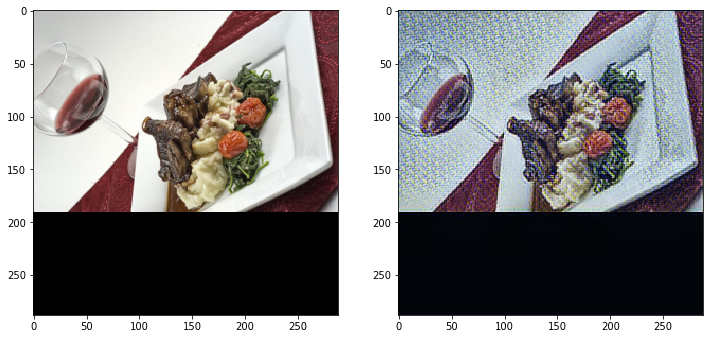

In [179]:
compare_output(arr_hr[9].astype('uint8'), preds[9].astype('uint8'))

As we can see, too little of the style has crept into our content image. But that can be fixed by increasing the style error. For now, the purpose of this notebook was to show that we can train a neural network itself to learn how to create stylized images, i.e. it can stylize any input content image with a particular style!